## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.


In [1]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

C:\Users\muhammad.tayyab01\Anaconda3\envs\model_deployment\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Prepare the data set
- Cleaning dataset

In [2]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [3]:
data.corr()

,pclass,survived,sibsp,parch
pclass,1.000000,-0.312469,0.060832,0.018322
survived,-0.312469,1.000000,-0.027825,0.082660
sibsp,0.060832,-0.027825,1.000000,0.373587
parch,0.018322,0.082660,0.373587,1.000000


In [4]:
# replace interrogation marks by NaN values
data = data.replace('?', np.nan)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [6]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [7]:
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,title
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",Miss
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22,S,11,NaN,"Montreal, PQ / Chesterville, ON",Master
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Miss
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22,S,NaN,135,"Montreal, PQ / Chesterville, ON",Mr
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",Mrs


In [8]:
# cast numerical variables as floats
data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [9]:
# drop unnecessary variables
data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)
# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [10]:
# save the data set
data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   int64  
 1   survived  1309 non-null   int64  
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   int64  
 5   parch     1309 non-null   int64  
 6   fare      1308 non-null   float64
 7   cabin     295 non-null    object 
 8   embarked  1307 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 102.4+ KB


In [12]:
target = 'survived'

In [13]:
vars_num = [var for var in data.columns if var != target and data[var].dtype != 'O']
vars_cat = [var for var in data.columns if data[var].dtype == 'O']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [14]:
# first in numerical variables
data[vars_num].isnull().mean()

pclass    0.000000
age       0.200917
sibsp     0.000000
parch     0.000000
fare      0.000764
dtype: float64

In [15]:
# now in categorical variables
data[vars_cat].isnull().mean()

sex         0.000000
cabin       0.774637
embarked    0.001528
title       0.000000
dtype: float64

In [16]:
# Total missing values variables
var_missing_data = [var for var in data.columns if data[var].isnull().sum() > 0]
data[var_missing_data].isnull().mean()

age         0.200917
fare        0.000764
cabin       0.774637
embarked    0.001528
dtype: float64

In [17]:
var_missing_int =  [var for var in vars_num if data[var].isnull().sum() > 0]
var_missing_cat =  [var for var in vars_cat if data[var].isnull().sum() > 0]

Text(0, 0.5, 'Percentage of missing data')

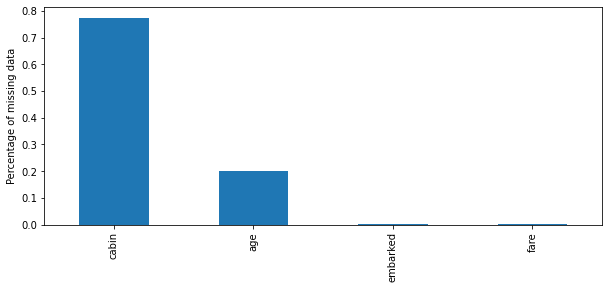

In [18]:
data[var_missing_data].isnull().mean().sort_values(ascending=False).plot.bar(figsize=(10,4))
plt.ylabel('Percentage of missing data')

### Determine cardinality of categorical variables

In [19]:
data[vars_cat].nunique()

sex           2
cabin       181
embarked      3
title         5
dtype: int64

<AxesSubplot:>

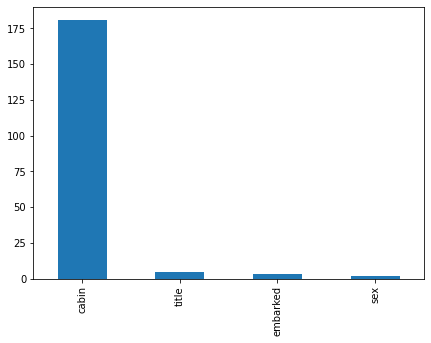

In [20]:
data[vars_cat].nunique().sort_values(ascending=False).plot.bar(figsize=(7,5))

### Determine the distribution of numerical variables

In [21]:
data[vars_num].nunique()

pclass      3
age        98
sibsp       7
parch       8
fare      281
dtype: int64

array([[<AxesSubplot:title={'center':'pclass'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'sibsp'}>,
        <AxesSubplot:title={'center':'parch'}>],
       [<AxesSubplot:title={'center':'fare'}>, <AxesSubplot:>]],
      dtype=object)

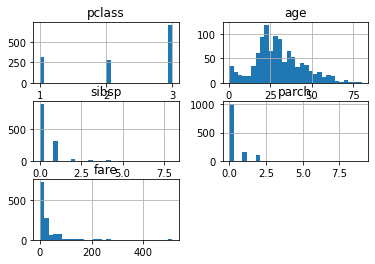

In [22]:
data[vars_num].hist(bins=30)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 9), (262, 9))

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [24]:
def extract_letters(value):
    try:
        return value[0]
    except:
        return np.nan
data['cabin'] = data.cabin.apply(extract_letters)
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C,S,Master
2,1,0,female,2.0000,1,2,151.5500,C,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C,S,Mrs


### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [25]:
for col in var_missing_int:
    X_train[col + '_na'] = np.where(X_train[col].isnull(), 1, 0)
    X_test[col + '_na'] = np.where(X_test[col].isnull(), 1, 0)

    X_train[col].fillna(X_train[col].median(), inplace=True) 
    X_test[col].fillna(X_test[col].median(), inplace=True) 
X_train[var_missing_int].isnull().sum()    

age     0
fare    0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [26]:
for col in var_missing_cat:
    X_train[col] = X_train[col].fillna('missing')
    X_test[col] = X_test[col].fillna('missing')
display(X_train[var_missing_cat].isnull().sum())    
display(X_train[var_missing_cat].isnull().sum())    

cabin       0
embarked    0
dtype: int64

cabin       0
embarked    0
dtype: int64

In [27]:
X_train.isna().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_na      0
fare_na     0
dtype: int64

In [28]:
X_test.isna().sum()

pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    0
title       0
age_na      0
fare_na     0
dtype: int64

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [29]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the passengers in the dataset
    df = df.copy()
    
    tmp = df.groupby(var)[var].count() / len(df)
    
    return tmp[tmp > rare_perc].index


for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.05)
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')

In [30]:
X_train[vars_cat].nunique()

sex         2
cabin       2
embarked    4
title       4
dtype: int64

In [31]:
X_test[vars_cat].nunique()

sex         2
cabin       2
embarked    3
title       4
dtype: int64

### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [35]:
for var in vars_cat:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[var], prefix=var, drop_first=True)], axis=1)
    
    X_test = pd.concat([X_test, pd.get_dummies(X_test[var], prefix=var, drop_first=True)], axis=1)
X_train

,pclass,sex,age,sibsp,parch,fare,cabin,embarked,title,age_na,fare_na,sex_male,cabin_missing,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,male,25.0000,0,0,7.9250,missing,S,Mr,0,0,1,1,0,0,1,1,0,0
44,1,female,41.0000,0,0,134.5000,Rare,C,Miss,0,0,0,0,0,0,0,0,0,0
1072,3,male,28.0000,0,0,7.7333,missing,Q,Mr,1,0,1,1,1,0,0,1,0,0
1130,3,female,18.0000,0,0,7.7750,missing,S,Miss,0,0,0,1,0,0,1,0,0,0
574,2,male,29.0000,1,0,21.0000,missing,S,Mr,0,0,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,female,0.1667,1,2,20.5750,missing,S,Miss,0,0,0,1,0,0,1,0,0,0
835,3,male,28.0000,0,0,8.0500,missing,S,Mr,1,0,1,1,0,0,1,1,0,0
1216,3,female,28.0000,0,0,7.7333,missing,Q,Miss,1,0,0,1,1,0,0,0,0,0
559,2,female,20.0000,0,0,36.7500,missing,S,Miss,0,0,0,1,0,0,1,0,0,0


In [36]:
X_train.drop(labels=vars_cat, inplace=True, axis=1)
X_test.drop(labels=vars_cat, inplace=True, axis=1)
X_train

,pclass,age,sibsp,parch,fare,age_na,fare_na,sex_male,cabin_missing,embarked_Q,embarked_Rare,embarked_S,title_Mr,title_Mrs,title_Rare
1118,3,25.0000,0,0,7.9250,0,0,1,1,0,0,1,1,0,0
44,1,41.0000,0,0,134.5000,0,0,0,0,0,0,0,0,0,0
1072,3,28.0000,0,0,7.7333,1,0,1,1,1,0,0,1,0,0
1130,3,18.0000,0,0,7.7750,0,0,0,1,0,0,1,0,0,0
574,2,29.0000,1,0,21.0000,0,0,1,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,3,0.1667,1,2,20.5750,0,0,0,1,0,0,1,0,0,0
835,3,28.0000,0,0,8.0500,1,0,1,1,0,0,1,1,0,0
1216,3,28.0000,0,0,7.7333,1,0,0,1,1,0,0,0,0,0
559,2,20.0000,0,0,36.7500,0,0,0,1,0,0,1,0,0,0


In [37]:
print(X_train.shape)
print(X_test.shape)

(1047, 15)
(262, 14)


In [38]:
X_test['embarked_Rare'] = 0

In [39]:
variables = [x for x in X_train.columns]
variables

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'age_na',
 'fare_na',
 'sex_male',
 'cabin_missing',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Mr',
 'title_Mrs',
 'title_Rare']

### Scale the variables

- Use the standard scaler from Scikit-learn

In [42]:
from sklearn.preprocessing import StandardScaler

In [46]:
scaler = StandardScaler()
scaler.fit(X_train[variables])
X_train = pd.DataFrame(scaler.transform(X_train[variables]))
X_test = pd.DataFrame(scaler.transform(X_test[variables]))
display(X_train)
display(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.835808,-0.370162,-0.478911,-0.455423,-0.504782,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778
1,-1.542157,0.904029,-0.478911,-0.455423,1.971555,-0.494921,-0.03092,-1.313987,-1.814107,-0.319539,-0.043748,-1.563355,-1.149569,-0.435629,-0.275778
2,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,2.020526,-0.03092,0.761042,0.551235,3.129507,-0.043748,-1.563355,0.869892,-0.435629,-0.275778
3,0.835808,-0.927621,-0.478911,-0.455423,-0.507717,-0.494921,-0.03092,-1.313987,0.551235,-0.319539,-0.043748,0.639650,-1.149569,-0.435629,-0.275778
4,-0.353174,-0.051614,0.434422,-0.455423,-0.248980,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,0.835808,-2.347810,0.434422,1.910970,-0.257295,-0.494921,-0.03092,-1.313987,0.551235,-0.319539,-0.043748,0.639650,-1.149569,-0.435629,-0.275778
1043,0.835808,-0.131251,-0.478911,-0.455423,-0.502337,2.020526,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.639650,0.869892,-0.435629,-0.275778
1044,0.835808,-0.131251,-0.478911,-0.455423,-0.508533,2.020526,-0.03092,-1.313987,0.551235,3.129507,-0.043748,-1.563355,-1.149569,-0.435629,-0.275778
1045,-0.353174,-0.768347,-0.478911,-0.455423,0.059156,-0.494921,-0.03092,-1.313987,0.551235,-0.319539,-0.043748,0.639650,-1.149569,-0.435629,-0.275778


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.835808,0.665118,-0.478911,-0.455423,-0.505353,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778
1,-0.353174,-0.688710,-0.478911,0.727773,-0.248980,-0.494921,-0.03092,-1.313987,0.551235,-0.319539,-0.043748,0.63965,-1.149569,-0.435629,-0.275778
2,-0.353174,0.983666,0.434422,-0.455423,-0.131595,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778
3,0.835808,-0.290525,-0.478911,-0.455423,-0.376148,2.020526,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778
4,-0.353174,-0.370162,-0.478911,-0.455423,-0.043556,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.835808,-0.609073,-0.478911,-0.455423,-0.502337,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778
258,0.835808,-0.290525,-0.478911,-0.455423,-0.505353,2.020526,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778
259,-0.353174,0.028023,-0.478911,-0.455423,-0.405494,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778
260,-0.353174,-0.290525,-0.478911,-0.455423,-0.405494,-0.494921,-0.03092,0.761042,0.551235,-0.319539,-0.043748,0.63965,0.869892,-0.435629,-0.275778


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [49]:
l_regression = LogisticRegression(C=0.0005, random_state=0)
l_regression.fit(X=X_train, y=y_train)

LogisticRegression(C=0.0005, random_state=0)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [55]:
train_pred = l_regression.predict(X_train)
pred = l_regression.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, train_pred)))
print()



# make predictions for test set
class_ = l_regression.predict(X_test)
pred = l_regression.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.8417078825347758
train accuracy: 0.7039159503342884

test roc-auc: 0.8378086419753087
test accuracy: 0.7061068702290076

